### Ejemplo de dataframe para la gráfica areaplot2

In [1]:
import pandas as pd
import numpy as np

# Generar datos
fechas = pd.date_range(start="2000-01-01", end="2025-12-31", freq="YE")
n = len(fechas)

# Generar valores aleatorios que suben con el tiempo y caen bruscamente al final
valores = {
    "Fecha": fechas,
    "Columna1": np.concatenate([
        np.sort(np.random.uniform(100, 4000, n - 5)),  # Valores ascendentes aleatorios
        np.random.uniform(500, 1000, 5)  # Caída brusca al final
    ]),
    "Columna2": np.concatenate([
        np.sort(np.random.uniform(200, 3500, n - 5)),
        np.random.uniform(300, 800, 5)
    ]),
    "Columna3": np.concatenate([
        np.sort(np.random.uniform(300, 3000, n - 5)),
        np.random.uniform(100, 600, 5)
    ]),
    "Columna4": np.concatenate([
        np.sort(np.random.uniform(400, 2500, n - 5)),
        np.random.uniform(50, 500, 5)
    ]),
}

# Crear DataFrame
df = pd.DataFrame(valores)

# Mostrar el DataFrame
print(df)

        Fecha     Columna1     Columna2     Columna3     Columna4
0  2000-12-31   175.987485   275.937675   406.206410   666.535202
1  2001-12-31   255.121075   452.215171   456.430066   712.041277
2  2002-12-31   437.619260   628.045403   560.483380   827.008594
3  2003-12-31   752.940981   868.566487   572.055534   899.647505
4  2004-12-31   945.435869  1166.218450   879.564882  1170.152787
5  2005-12-31  1131.247509  1172.146818   923.242708  1284.175917
6  2006-12-31  1141.905968  1229.122159  1015.931988  1293.814136
7  2007-12-31  1272.744850  1272.747730  1083.566058  1446.202600
8  2008-12-31  2114.986482  1311.147544  1211.478235  1529.313484
9  2009-12-31  2138.404514  1440.526726  1361.681144  1613.916553
10 2010-12-31  2202.775801  1668.761862  1439.396797  1691.332990
11 2011-12-31  2466.660867  1997.677793  1667.707656  1693.359519
12 2012-12-31  2886.636677  2110.161084  1964.251689  1704.567249
13 2013-12-31  2912.690673  2203.171091  2053.717520  1853.185187
14 2014-12

In [2]:
import subprocess

def limpiar_svg_con_scour(archivo_entrada, archivo_salida):
    subprocess.run([
        'scour', '-i', archivo_entrada, '-o', archivo_salida,
        '--enable-viewboxing', '--enable-id-stripping',
        '--shorten-ids', '--remove-descriptive-elements'
    ], check=True)

def limpiar_svg_con_svgo(archivo_entrada, archivo_salida):
    subprocess.run(['svgo', archivo_entrada, '-o', archivo_salida], check=True)


Scour processed file "areaplot2.svg" in 74 ms: 37759/62949 bytes new/orig -> 60.0%

areaplot2_limpio.svg:
Done in 67 ms!
36.874 KiB - 11.9% = 32.486 KiB


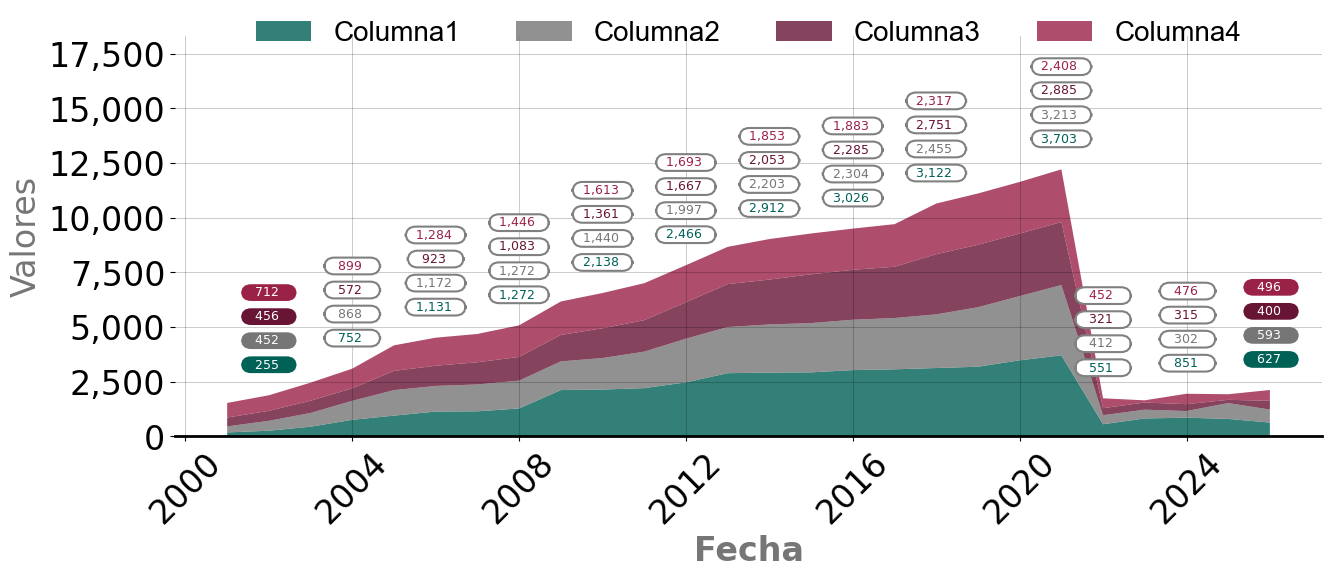

In [4]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.ticker as mticker
import pandas as pd

# VARIABLES A CAMBIAR
dataframe_a_graficar = df
columna_fecha = "Fecha"

# Obtener las columnas a graficar (excluyendo la columna de fecha)
columnas_a_graficar = [col for col in df.columns if col != columna_fecha]


def obtener_indices_a_omitir(
    df,
    columnas,
    incluir_min=False,
    incluir_max=False,
    omitir_antes_del_max=False
):
    indices_a_omitir = set()

    for col in columnas:
        if pd.api.types.is_numeric_dtype(df[col]):
            if omitir_antes_del_max:
                idx_max = df[col].idxmax()
                pos = df.index.get_loc(idx_max)
                if pos > 0:
                    idx_antes = df.index[pos - 1]
                    indices_a_omitir.add(idx_antes)

            if not incluir_max:
                indices_a_omitir.add(df[col].idxmax())
            if not incluir_min:
                indices_a_omitir.add(df[col].idxmin())

    return list(indices_a_omitir)

indices_a_omitir = obtener_indices_a_omitir(df, 
                                            columnas_a_graficar, 
                                            incluir_max=True, # mostrar el máximo
                                            incluir_min=True, # mostrar el máximo
                                            omitir_antes_del_max=True) # quitar la columna que se encima pero ver todos los demás

def ajusta_etiquetas_apiladas_manual(dataframe, columnas, colores, columna_x, sin_tag=1, etiquetar_max=True, bbox_props=None, fontsize=12, separacion=40, indices_a_omitir=None):
    """
    Ajusta las etiquetas de los puntos en una gráfica apilada, colocándolas por encima del punto más alto
    y apilándolas verticalmente en orden correcto.

    Args:
        dataframe (pd.DataFrame): DataFrame con los datos.
        columnas (list): Columnas a etiquetar.
        colores (list): Colores para cada etiqueta.
        columna_x (str): Columna para el eje X.
        sin_tag (int): Puntos sin etiqueta entre etiquetas. Default: 2.
        etiquetar_max (bool): Si True, etiqueta el valor máximo de cada columna. Default: True.
        bbox_props (dict): Propiedades del fondo de la etiqueta. Default: None (estilo predeterminado).
        fontsize (int): Tamaño de fuente. Default: 12.
        separacion (int): Separación vertical entre etiquetas (en unidades Y). Default: 40.
    """
    plt.rcParams['svg.fonttype'] = 'none'
    font_dirs = [Path("../0_fonts")]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    
    if indices_a_omitir is None:
                indices_a_omitir = set()
    else:
        indices_a_omitir = set(indices_a_omitir)
        
    # Calcular la altura acumulada máxima en cada punto X
    acumulado = dataframe[columnas].cumsum(axis=1)
    y_max_global = acumulado.max(axis=1)  # Altura máxima en cada X

    # Diccionario para guardar la posición Y más alta ocupada en cada X
    y_max_por_x = {col: {} for col in columnas} 

    for col, color in zip(columnas, colores):
        for i, row in dataframe.iterrows():
            x_pos = row[columna_x]
        total_puntos = len(dataframe)
        max_index = dataframe[col].idxmax() if etiquetar_max else None  # Índice del máximo si etiquetar_max=True

        for i, row in dataframe.iterrows():
            x_pos = row[columna_x]  # Posición X actual
            tiene_etiqueta = (
                (total_puntos - i - 1) % (sin_tag + 1) == 0  # Cada 'sin_tag' puntos
                or i == total_puntos - 1  # Siempre etiquetar el último punto
                or (etiquetar_max and i == max_index)  # Etiquetar el máximo si etiquetar_max=True
            )

            if (
                i not in indices_a_omitir and (
                    (total_puntos - i - 1) % (sin_tag + 1) == 0
                    or i == total_puntos - 1
                    or (etiquetar_max and i == max_index)
                )
            ):
            
                if tiene_etiqueta:
                    # Altura base: el punto más alto en esta posición X
                    y_base = y_max_global[i]
                    # Si ya hay una etiqueta en esta X, apilarla encima de la última
                    if x_pos in y_max_por_x:
                        y_etiqueta = y_max_por_x[x_pos] + separacion
                    else:
                        y_etiqueta = y_base + separacion  # Espacio inicial por encima del punto más alto

                # Actualizar la altura máxima registrada para esta X
                y_max_por_x[x_pos] = y_etiqueta

                # Configurar el fondo de la etiqueta para puntos intermedios
                if i != 1 and i != total_puntos - 1:  # Puntos intermedios
                    bbox_props_intermedio = dict(boxstyle="round,pad=0.15,rounding_size=0.8", fc="white", ec="gray", alpha=1.0, linewidth=1.5)
                    texto_color = color  # Mismo color que la gráfica
                else:  # Puntos máximos o finales
                    bbox_props_intermedio = bbox_props or dict(boxstyle="round,pad=0.15,rounding_size=0.8", fc=color, ec="none", alpha=1.0, linewidth=1.5)
                    texto_color = "white"  # Texto blanco para máximos/finales
                
                # Añadir la etiqueta
                texto_capsula = f"{int(row[col]):,}".center(10)

                fechas_criticas = dataframe[columna_x].iloc[-3:].values

                if pd.api.types.is_datetime64_any_dtype(dataframe[columna_x]):
                    if x_pos in fechas_criticas:
                        x_pos_mod = x_pos + pd.Timedelta(days=10)
                    else:
                        x_pos_mod = x_pos
                else:
                    if x_pos in fechas_criticas:
                        x_pos_mod = str(x_pos) + "0.8"  # leve separación visual si es string
                    else:
                        x_pos_mod = x_pos

                plt.text(
                    x_pos_mod,
                    y_etiqueta,
                    texto_capsula,
                    fontsize=fontsize,
                    color=texto_color,
                    ha='center',
                    va='bottom',
                    bbox=bbox_props_intermedio
                )

def areaplot2(df, columna_fecha):
    """
    Genera una gráfica de área (area plot) a partir de un DataFrame.

    Args:
        df (pd.DataFrame): DataFrame que contiene los datos a graficar.
        columna_fecha (str): Nombre de la columna que se usará como eje X.
        tipografia (FontProperties, optional): Fuente personalizada para los textos. Por defecto es None.
    """
    font_config = {
        'family': 'Arial',  # Cambiar a Arial
        'titulo': {'size': 36, 'weight': 'medium', 'color': '#000000'},
        'eje_y': {'size': 24, 'weight': 'medium', 'color': '#000000'},
        'eje_x': {'size': 24, 'weight': 'medium', 'color': '#000000'},
        'etiquetas_eje_y': {'size': 24, 'weight': 'medium', 'color': '#767676'},
        'etiquetas_eje_x': {'size': 24, 'weight': 'semibold', 'color': '#767676'},
        'capsula_valor': {'size': 9, 'weight': 'medium', 'color': '#10302C'},
        'capsula_max': {'size': 12, 'weight': 'medium', 'color': 'white'},
        'porcentaje': {'size': 10, 'weight': 'medium', 'color': '#4C6A67'},
        'leyenda': {'size': 20, 'weight': 'medium', 'color': '#767676'}  # Nueva categoría para la leyenda
    }

    plt.rcParams['svg.fonttype'] = 'none'
    font_dirs = [Path("../0_fonts")]
    font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
    for font_file in font_files:
        font_manager.fontManager.addfont(font_file)
    
    # Verificar que la columna especificada exista en el DataFrame
    if columna_fecha not in df.columns:
        raise ValueError(f"La columna '{columna_fecha}' no existe en el DataFrame.")
    
    # Configurar el tamaño de la figura en píxeles
    ancho_px = 1480
    alto_px = 520
    dpi = 100  # Resolución en píxeles por pulgada
    ancho_in = ancho_px / dpi
    alto_in = alto_px / dpi
    
    # Crear la figura con el tamaño especificado
    fig, ax = plt.subplots(figsize=(ancho_in, alto_in), dpi=dpi)
    
    # Obtener los colores
    colores_asignados = ["#006157", "#767676", "#671435", "#9B2247", "#9D792A", "#D5B162"]
    
    # Graficar el área para cada columna
    ax.stackplot(
        df[columna_fecha],
        [df[col] for col in columnas_a_graficar],
        labels=columnas_a_graficar,
        colors=colores_asignados[:len(columnas_a_graficar)],
        alpha=0.8
    )

    # Configurar etiquetas y título
    ax.set_xlabel(columna_fecha, fontdict=font_config['etiquetas_eje_x'])
    ax.set_ylabel("Valores", fontdict=font_config['etiquetas_eje_y'])

    # Rotar las etiquetas del eje X
    plt.xticks(rotation=45, fontsize=font_config['eje_x']['size'], color=font_config['eje_x']['color'])
    plt.yticks(fontsize=font_config['eje_y']['size'], color=font_config['eje_y']['color'])
    
    # Posicionar la leyenda debajo del título y arriba de la gráfica
    ax.legend(
        loc='upper center',
        bbox_to_anchor=(0.5, 1.1),
        ncol=len(columnas_a_graficar),
        frameon=False,  # Opcional: eliminar el fondo de la leyenda
        prop=font_manager.FontProperties(
            family=font_config['family'],
            size=font_config['leyenda']['size'],
            weight=font_config['leyenda']['weight']
        )
    )

    # Desactivar o activar bordes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(True)

    # Asignar grosor a los ejes visibles
    ax.spines['bottom'].set_linewidth(2)  # Grosor del eje inferior

    # Formatear los números del eje Y con comas
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

    # Mantener las líneas del grid
    ax.grid(axis='y', linestyle='-', color='#000000', alpha=0.2, linewidth=0.75)
    ax.grid(axis='x', linestyle='-', color='#000000', alpha=0.2, linewidth=0.75)

    # Ajustar etiquetas en los puntos máximos de cada columna
    ajusta_etiquetas_apiladas_manual(
        dataframe=df,
        columnas=columnas_a_graficar,
        colores=colores_asignados,
        columna_x=columna_fecha,
        fontsize=font_config['capsula_valor']['size'],
        separacion=1100,
        indices_a_omitir=indices_a_omitir
    )

    # Calcular el valor máximo de las etiquetas y agregar un margen
    y_max = df[columnas_a_graficar].sum(axis=1).max()  # Suma acumulada máxima
    margen = y_max * 0.5  # Margen del 10%
    ax.set_ylim(0, y_max + margen)  # Ajustar el límite del eje Y

    nombre_svg = "areaplot2.svg"
    nombre_svg_limpio = "areaplot2_limpio.svg"
    nombre_svg_svgo = "areaplot2_svgo.svg"

    plt.savefig(nombre_svg, format="svg", bbox_inches='tight', dpi=dpi)

    # Limpieza con Scour
    limpiar_svg_con_scour(nombre_svg, nombre_svg_limpio)

    # Limpieza con SVGO
    limpiar_svg_con_svgo(nombre_svg_limpio, nombre_svg_svgo)

    plt.show()


# Llamar a la función con el DataFrame df, la columna 'Fecha' y la fuente personalizada
areaplot2(dataframe_a_graficar, columna_fecha=columna_fecha)
